# FinOpt — Simulation & Optimization Demo

This notebook showcases the **current MVP** of FinOpt:

- Income modeling → monthly contributions
- Three-case deterministic scenarios (base/optimistic/pessimistic)
- Monte Carlo simulation (IID lognormal)
- Optimization solvers: minimum contribution (closed-form), minimum time (binary search)
- Goal evaluation & chance-constraints
- (Bonus) Multi-asset portfolio simulation


## 0) Setup

In [1]:
# --- Path setup: add project root so "src" is importable ---
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# --- Standard libs ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

# --- FinOpt modules (desde /src) ---
from src.income import FixedIncome, VariableIncome, IncomeModel
from src.investment import (
    simulate_capital, simulate_portfolio
)
from src.simulation import ScenarioConfig, SimulationEngine
from src.goals import Goal, evaluate_goals
from src.utils import summary_metrics


## 1) Income model → contributions

In [25]:
seasonality_norm = [
    0.00,  # Jan
    0.00,  # Feb
    0.00,  # Mar
    1.32,  # Apr
    1.48,  # May
    1.36,  # Jun
    1.24,  # Jul
    1.18,  # Aug
    0.87,  # Sep (reducido)
    1.16,  # Oct
    1.28,  # Nov
    1.31,  # Dec
]

income = IncomeModel(
    fixed=FixedIncome(base=1_400_000.0, annual_growth=0.10),
    variable=VariableIncome(
        base=150_000.0,
        seasonality=seasonality_norm,
        sigma=0.10,         # 10% de ruido mensual
        floor=50_000.0,     # piso mínimo
        cap=400_000.0,      # techo máximo
        annual_growth=0.02,
        seed=42
    ),
)

months = 24
start = date(2025, 9, 1)

# Proportional contribution rule: 35% of fixed + 100% of variable
alpha, beta = 0.35, 1.0
contributions = income.contributions(months=months, alpha_fixed=alpha, beta_variable=beta, start=start)
contributions.head()

2025-09-01    624476.557891
2025-10-01    650069.093950
2025-11-01    704936.842570
2025-12-01    717864.745764
2026-01-01    555817.256574
Freq: MS, Name: contribution, dtype: float64

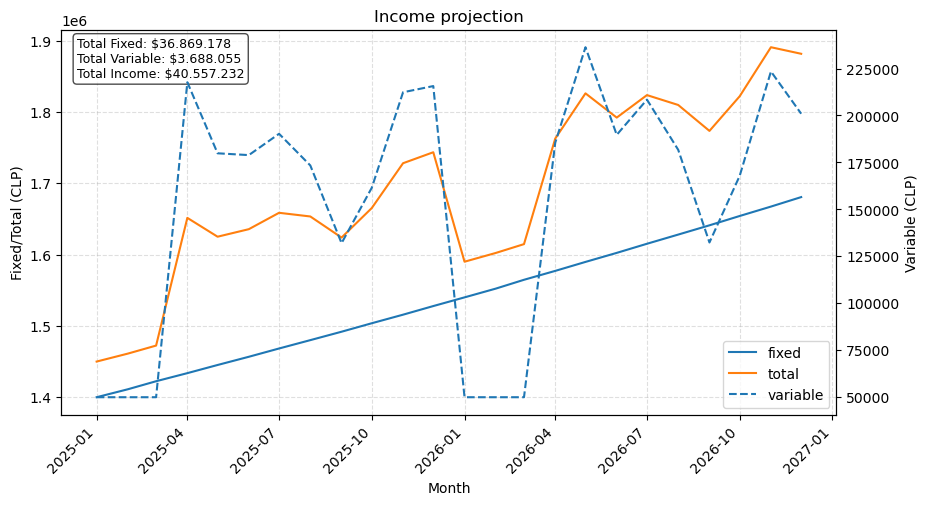

In [26]:
income.plot(months=24, start=date(2025, 1, 1), kind="lines", dual_axis=True,
            title="Income projection")

In [27]:
# Summary for 24 months
summary_24m = income.summary(months=24, start=date(2025, 9, 1))
print("=== Summary (24 months) ===")
print(summary_24m)

=== Summary (24 months) ===
months                    24.00
total_income        40635230.46
total_fixed         36869177.64
total_variable       3766052.82
mean_total           1693134.60
mean_fixed           1536215.74
mean_variable         156918.87
fixed_share                0.91
variable_share             0.09
std_variable           67157.35
coefvar_variable           0.43
dtype: float64


In [28]:
# Detailed metrics for 24 months, with a safety floor check (variable < 150k)
metrics_24m = income.income_metrics(
    months=24, 
    start=date(2025, 9, 1), 
    variable_threshold=150_000.0
)
print("=== Income Metrics (24 months) ===")
metrics_24m

=== Income Metrics (24 months) ===


IncomeMetrics(months=24, total_fixed=36869177.64005546, total_variable=3766052.818955021, total_income=40635230.45901048, mean_fixed=1536215.735002311, mean_variable=156918.8674564592, mean_total=1693134.6024587702, std_variable=67157.34773209643, coefvar_variable=0.4279749708920809, fixed_share=0.9073205005505283, variable_share=0.09267949944947178, min_variable=50000.0, max_variable=225207.57183368623, pct_variable_below_threshold=0.3333333333333333)

In [36]:
# Configuración de escenario (24 meses)
cfg = ScenarioConfig(
    months=24,
    start=date(2025, 9, 1),
    alpha_fixed=0.35,
    beta_variable=1.0,
    base_r=0.004,        # 0.4% mensual
    optimistic_r=0.007,
    pessimistic_r=0.001,
)

sim = SimulationEngine(income, cfg)

results = sim.run_three_cases()

# Mostrar métricas comparativas
summary_metrics(results)


,final_wealth,total_contributions,cagr,vol,max_drawdown
scenario,,,,,
base,1.750304e+07,1.667026e+07,4.283622,0.223508,0.0
optimistic,1.816160e+07,1.667026e+07,4.374082,0.223827,0.0
pessimistic,1.687376e+07,1.667026e+07,4.195542,0.223182,0.0


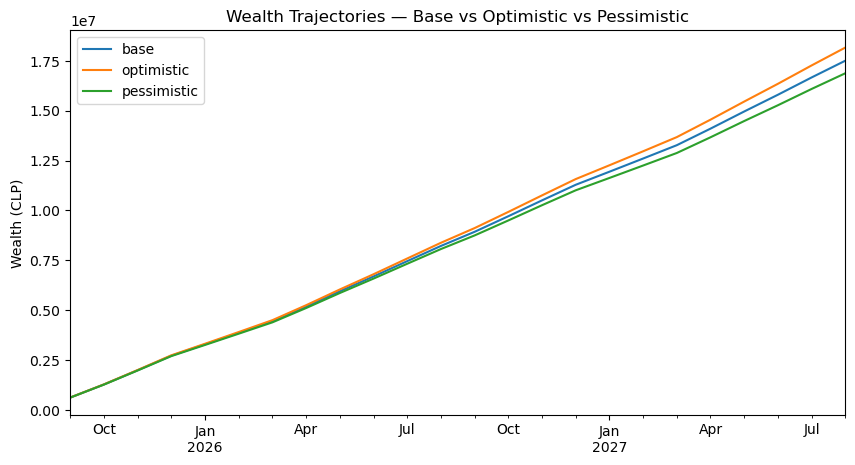

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
for name, res in results.items():
    res.wealth.plot(ax=ax, label=name)

ax.set_title("Wealth Trajectories — Base vs Optimistic vs Pessimistic")
ax.set_ylabel("Wealth (CLP)")
ax.legend()
plt.show()


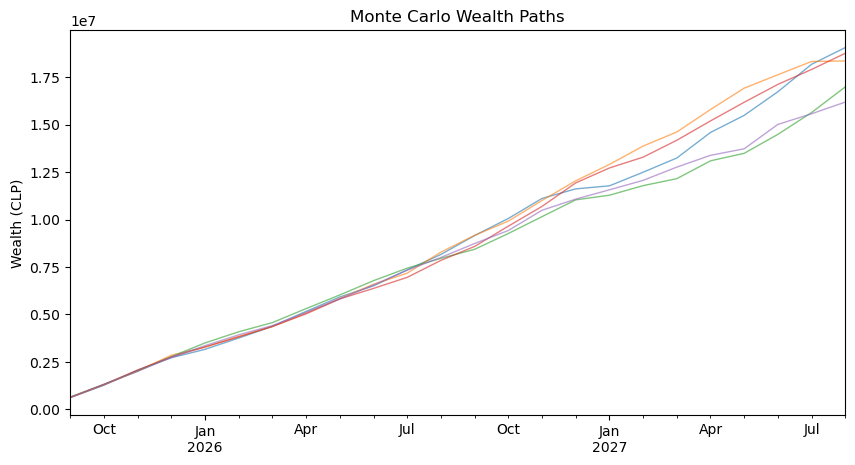

In [38]:
# Ajustamos config para activar Monte Carlo
cfg_mc = ScenarioConfig(
    months=24,
    start=date(2025, 9, 1),
    alpha_fixed=0.35,
    beta_variable=1.0,
    mc_mu=0.004,
    mc_sigma=0.02,
    mc_paths=5,    # correr 5 caminos
    seed=123
)

sim_mc = SimulationEngine(income, cfg_mc)
mc_results = sim_mc.run_monte_carlo()

# Graficar caminos
fig, ax = plt.subplots(figsize=(10, 5))
for name, res in mc_results.items():
    res.wealth.plot(ax=ax, alpha=0.6, lw=1)
ax.set_title("Monte Carlo Wealth Paths")
ax.set_ylabel("Wealth (CLP)")
plt.show()


In [39]:
# Definir objetivos
goals = [
    Goal("housing", target_amount=20_000_000.0, target_month_index=23),
    Goal("emergency", target_amount=6_000_000.0, target_month_index=11),
]

# Evaluar sobre escenario base
df_goals = evaluate_goals(results["base"].wealth, goals)
df_goals


,goal,deadline_pos,deadline_timestamp,target_amount,wealth_at_deadline,success,shortfall,attainment_ratio,priority
0,emergency,11,2026-08-01,6000000.0,8.222737e+06,True,0.000000e+00,1.000000,0
1,housing,23,2027-08-01,20000000.0,1.750304e+07,False,2.496963e+06,0.875152,0
